# Some installation to work with data

these installations can be found by [the link to a video](https://www.youtube.com/watch?v=57N1g8k2Hwc&t=515s)

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"milanashhanukova","key":"5bb9077a74255439ac5e86081492face"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.6MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.5MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.9MB/s]


# Data preprocessing

In [8]:
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go

In [9]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

**STEP 1:**
- distribution of data parameters 
- data visualization

In [10]:
# number of target values
fig = go.Figure([go.Bar(x=train_data["target"].unique(), y=train_data["target"].value_counts())])
fig.show()

We have more disaster tweets, but the difference is not so high, so we can work with it.

Also we have a column keyword, but there are some nans. The percentage is not so high, so that is not a problem and we can work with it.

In [11]:
train_data["keyword"].isnull().sum() / len(train_data["keyword"])

0.008012610009194798

The most common one common keyword is "fatalities".  

In [12]:
train_data["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Let's analyze location data and how many points we miss. There is nearly 0.33% of missing data. That is not appropriate if we want to use it in the model.

In [13]:
train_data["location"].isnull().sum() / len(train_data["location"])

0.33272034677525286

## Work with  nans in location and keyword

- add new information in keywords 
- find places in tweets and add information in location

In [14]:
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
import re
from string import punctuation
import json

nlp = spacy.load("en_core_web_sm") #english mode
my_punctuation = punctuation.replace("#", "") #we are gonna take all tags, so leave #

In [28]:
# all functions for some preprocessing
def get_place(place, nlp_text):
  if place is np.NaN:
    tags = []
  else: 
    tags = place.split()
  nlp_text = nlp(nlp_text)
  tags = tags + [ent.text for ent in nlp_text.ents if ent.label_ =="GPE"]
  if not tags: 
    return np.NaN
  return tags 

def get_lemmas(nlp_text):
  nlp_text = nlp(nlp_text)
  return " ".join([text.lemma_ for text in nlp_text if text.lemma_ not in STOP_WORDS])

def get_hashs(tags, text):
  if tags is np.NaN:
    tags = []
  else: 
    tags = [tag.replace("%", " ") for tag in tags.split(" ")]
  tags = tags + [w[1:] for w in text.split(" ") if w.startswith("#")]
  if not tags: 
    return np.NaN
  return " ".join(tags)

def get_rid_punctuation(text):
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('\n', '', text)
  text = text.translate(str.maketrans("", "", my_punctuation))
  text = re.sub(r'[0-9]+', '', text.lower())
  return text

grammar_abbs.update(slang_abbs)
contractions_re = re.compile('(%s)' % '|'.join(grammar_abbs.keys()))

def replace_abb(txt, abb=grammar_abbs):
    ctxt = re.sub(r'\s+', ' ', txt)
    res = []
    for tok in ctxt.split():
        if tok.lower() in abb:
            res.append(abb[tok.lower()])
        else:
            res.append(tok)
    res = ' '.join(res)
    return res.strip()

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

We want to understand all abbreviations. We use dicts for it. 
Thanks to [Arin](https://www.kaggle.com/arin006/cleaning-the-data-and-predict-using-transformers) for slang abbreviations and 
- [grammar abbreaviations](https://docs.google.com/document/d/1sRVM_lJoElViDLn-zeMhmvHd30VPFFqChbEmkUrfDjk/edit?usp=sharing)
- [slang abbreviations](https://docs.google.com/document/d/1o4uMRTyVrcj6JyYOVqL13_RRN_mZSNbPaS-SJ1JhZfg/edit?usp=sharing)

In [27]:
with open("grammar abbreviations.txt", encoding="utf-8") as f:
  gram_abb = f.read()

with open("slang abbreviations.txt", encoding="utf-8") as f:
  slang_abb = f.read()

grammar_abbs = json.loads(gram_abb,)
slang_abbs = json.loads(slang_abb)

In [25]:
train_data["keyword"] = train_data.apply(lambda x: get_hashs(x.keyword, x.text), axis = 1)
mis_per = train_data["keyword"].isnull().sum() / len(train_data["keyword"])
print(f"now the percentage of missing data in column keyword is {mis_per}")

now the percentage of missing data in column keyword is 0.005385524760278471


The value has not changed much, but let's check how our data looks like now. 

In [ ]:
train_data.head()

We can notice that now there are new tags, that are quite representative. 

In [29]:
train_data["text"] = train_data["text"].apply(lambda t: replace_abb(t)).apply(lambda t: remove_emoji(t)).apply(lambda t: get_rid_punctuation(t))

In [ ]:
train_data["location"] = train_data.apply(lambda x: get_place(x.location, x.text), axis = 1)
mis_dif = train_data["location"].isnull().sum() / len(train_data["location"])
print(f"we have gained more information {0.33272034677525286 - mis_dif} % and now the total number of missed data is {mis_dif}")

In [30]:
train_data.shape

(7613, 5)

In [31]:
train_data.drop_duplicates("text", inplace=True)

In [32]:
train_data.shape

(6924, 5)

In [33]:
train_data["text"] = train_data["text"].apply(lambda t: get_lemmas(t))

# Easy machine learning techniques



Here we age going to cover in a few details some concepts such as: 


*   [naive baise ](https://machinelearningmastery.com/naive-bayes-for-machine-learning/)
*   [svm ](https://habr.com/ru/company/ods/blog/484148/) russian variant 
* [tf-idf ](http://nlpx.net/archives/57) russian variant



In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [35]:
X, y = train_data["text"], train_data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
# classification with naive bayes

text_clf = Pipeline([
    ('vect', CountVectorizer()), #count matrix 
     ('tfidf', TfidfTransformer()), #normalized matrix 
    ('clf', MultinomialNB()),]) #naive bayes 

text_clf.fit(X_train, y_train)
predicted_naive = text_clf.predict(X_test)
print(f"mean accuracy is {np.mean(predicted_naive == y_test)}")
print(metrics.classification_report(y_test, predicted_naive))

In [ ]:
#classification with svm 
text_clf_2 = Pipeline([
    ('vect', CountVectorizer()), #count matrix
    ('tfidf', TfidfTransformer()), #normalized matrix 
    ('clf', SGDClassifier(penalty='l2', random_state=42, max_iter=100)), #svm
 ])

text_clf_2.fit(X_train, y_train)
predicted_svm = text_clf_2.predict(X_test)
print(f"mean accuracy is {np.mean(predicted_svm == y_test)}")
print(metrics.classification_report(y_test, predicted_svm))

## Merging two types of data: text and labels

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

labeler = MultiLabelBinarizer()

In [ ]:
# copy of data to predict on parametrs
data_2 = train_data.copy().fillna("no")
data_2["keyword"] = data_2.apply(lambda x: get_hashs(x.keyword, x.text), axis = 1).apply(lambda x: get_rid_punctuation(x)).apply(change_label)

In [ ]:
def change_label(labels):
  return tuple(labels.split(" "))

In [ ]:
Y=pd.DataFrame(labeler.fit_transform(data_2.keyword.values), columns=labeler.classes_, index=data_2.index)
Y.drop(columns="a", inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Y, data_2["target"], test_size=0.15, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

In [ ]:
predicted = knn.predict(X_test)
whole_prediction = (predicted + predicted_svm) //2

# LSTM

In [ ]:
import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [ ]:
text_train = train_data["text"].to_list()

In [ ]:
tokenizer = Tokenizer(num_words=3000, oov_token="<UNK>")
tokenizer.fit_on_texts(text_train)

In [ ]:
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(text_train)
maxlen = max([len(x) for x in train_sequences])
train_padded = pad_sequences(train_sequences, padding="post", truncating="post", maxlen=maxlen)

In [ ]:
test_data["text"] = test_data["text"].apply(lambda t: get_rid_punctuation(t)).apply(lambda t: remove_emoji(t))
test_lstm = np.array(test_data["text"].to_list())
test_sequences = tokenizer.texts_to_sequences(test_lstm)
test_padded = pad_sequences(test_sequences, padding="post", truncating="post", maxlen=maxlen)

In [ ]:
y = np.array(train_data["target"].to_list())

Thanks for baseline to [Saji](https://www.kaggle.com/basilb2s/disaster-tweet-classification-with-lstm)

In [ ]:
VOC_SIZE = 3000

def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=maxlen))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model

In [ ]:
model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary() #summary

In [ ]:
history = model.fit(train_padded, y, epochs=15, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history["accuracy"])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()

In [ ]:
predicted_lstm = model.predict(test_padded)

In [ ]:
p = pd.DataFrame({"id": np.array(test_data["id"].to_list()), 
                  "target": np.where(predicted_lstm > 0.5, 1, 0).squeeze(1)})
p.to_csv("d.csv", index=False)

# Bert

In [ ]:
!pip install transformers

In [38]:
from torch import nn
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
import torch

In [39]:
X_train = train_data["text"].values
y_train = train_data["target"].values

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

lens = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])

In [42]:
import matplotlib.pyplot as plt


text length mean:  17.17273252455228
text length median:  16.0
text length standard deviation:  7.231716241721948
suitable sequence length:  31.636165007996176


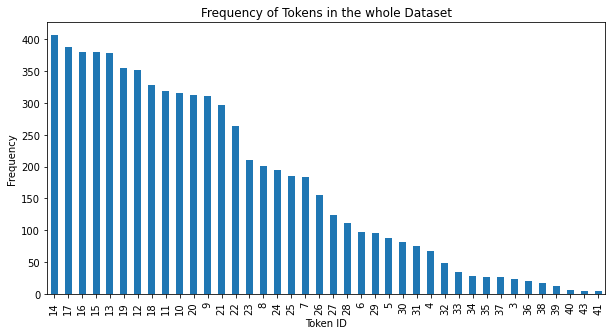

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Frequency of Tokens in the whole Dataset")
ax.set_xlabel("Token ID")
ax.set_ylabel("Frequency")
pd.Series(lens).value_counts().head(40).plot(kind="bar");
print("text length mean: ", np.array(lens).mean())
print("text length median: ", np.median(lens))
print("text length standard deviation: ", np.array(lens).std())
print("suitable sequence length: ", np.array(lens).mean() + 2*np.array(lens).std())

length = np.array(lens).mean() + 2*np.array(lens).std()

In [102]:
length

31.636165007996176

In [44]:
X_train_tokens = []

for text in X_train:
  encoded = tokenizer.encode_plus(text, 
                                  add_special_tokens=True, 
                                  max_length=int(length), 
                                  padding="max_length", 
                                  return_tensors="pt",
                                  truncation=True)
  X_train_tokens.append(encoded["input_ids"])

X_train_tokens = torch.cat(X_train_tokens, dim=0)
y_train = torch.tensor(y_train)

In [47]:
X_train_tokens

tensor([[  101,  1011,  4013,  ...,     0,     0,     0],
        [  101,  3224,  2543,  ...,     0,     0,     0],
        [  101,  6319,  3198,  ...,     0,     0,     0],
        ...,
        [  101,  2880, 24209,  ...,     0,     0,     0],
        [  101, 11238,  1011,  ...,     0,     0,     0],
        [  101,  5920,  9472,  ...,     0,     0,     0]])

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
batch_size = 32
# split into training and validation data
dataset = TensorDataset(X_train_tokens, y_train.float())
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

In [52]:
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

for batch in train_dataloader: 
    batch_features = batch[0].to(device)
    bert_output = bert(input_ids=batch_features)
    print("bert output: ", type(bert_output), len(bert_output))
    print("first entry: ", type(bert_output[0]), bert_output[0].size())
    print("second entry: ", type(bert_output[1]), bert_output[1].size())
    break

bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 31, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


In [53]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased') # returns pwerful representations of the microblogs
        self.linear = nn.Linear(768, 1) # custom layer; input of the first custom layer has to match the dimensionality of the BERT-output; further custom layers are possible
        self.sigmoid = nn.Sigmoid() # activation function applied to our custom layer to obtain probabilities
    
    def forward(self, tokens):
        bert_output = self.bert(input_ids=tokens)
        linear_output = self.linear(bert_output[1])
        proba = self.sigmoid(linear_output)
        return proba

In [54]:
def eval(y_batch, probas):
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    y_batch_np = y_batch.cpu().detach().numpy()
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    return acc, f1

    

def train(model, optimizer, scheduler, epochs, name):
    history = []
    best_f1 = 0
    model.train()
    for epoch in range(epochs):
        
        # ===== train =====
        print("=== Epoch: ", epoch+1, " / ", epochs, " ===")
        acc_total = 0
        f1_total = 0
        for it, batch in enumerate(train_dataloader): 
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)] # draw the batch
            probas = torch.flatten(model(tokens=x_batch))
            acc_f1_batch = eval(y_batch, probas)
            acc_total, f1_total = acc_total + acc_f1_batch[0], f1_total + acc_f1_batch[1]
            model.zero_grad() # reset the gradients
            loss_func = nn.BCELoss()
            batch_loss = loss_func(probas, y_batch)
            batch_loss.backward() # calculate gradient per (learnable) weight
            optimizer.step() # update (learnable) weights
            scheduler.step() # update learning rate
        acc_total = acc_total/len(train_dataloader) #len(train dataloader)=num_batches
        f1_total = f1_total/len(train_dataloader)
        print("accuracy: ", acc_total, "\nf1: ", f1_total)
      
        acc_val_total = 0
        f1_val_total = 0
        for batch in validation_dataloader:
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
            with torch.no_grad(): # gradients don't have to be computed, because no update is performed
                probas = torch.flatten(model(tokens=x_batch))
            acc_f1_val_batch = eval(y_batch, probas)
            acc_val_total, f1_val_total = acc_val_total + acc_f1_val_batch[0], f1_val_total + acc_f1_val_batch[1]
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        print("validation accuracy: ", acc_val_total, "\nvalidation f1: ", f1_val_total, "\n")
        if(f1_val_total>best_f1): # save current mdoel if this epoch improved models validation performance 
            torch.save(model, name+".pt")
            best_f1 = f1_val_total

        history.append({"acc":acc_total, "f1":f1_total, "acc_val":acc_val_total, "f1_val":f1_val_total})
    return [torch.load(name+".pt"), history]
  

In [56]:
epochs = 10
baseline_bert_clf = BertClassifier()
baseline_bert_clf = baseline_bert_clf.to(device)
adam = AdamW(baseline_bert_clf.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
sched = get_linear_schedule_with_warmup(adam, num_warmup_steps=0, num_training_steps=total_steps)

baseline_bert_clf, history = train(model=baseline_bert_clf, optimizer=adam, scheduler=sched, epochs=5, name="baseline_bert_clf")

=== Epoch:  1  /  5  ===
accuracy:  0.7626317049808429 
f1:  0.743517836779706
validation accuracy:  0.8117108585858586 
validation f1:  0.8054458305732409 

=== Epoch:  2  /  5  ===
accuracy:  0.8518318965517241 
f1:  0.8483236164312872
validation accuracy:  0.8237847222222222 
validation f1:  0.8188382369867973 

=== Epoch:  3  /  5  ===
accuracy:  0.8830818965517241 
f1:  0.8813426644406447
validation accuracy:  0.8124210858585859 
validation f1:  0.8092137150996949 

=== Epoch:  4  /  5  ===
accuracy:  0.9147509578544061 
f1:  0.912664146824379
validation accuracy:  0.8088699494949495 
validation f1:  0.8052378855552343 

=== Epoch:  5  /  5  ===
accuracy:  0.9403735632183908 
f1:  0.9395910211736962
validation accuracy:  0.8102904040404041 
validation f1:  0.8086567752567376 



In [58]:
history_df = pd.DataFrame(history)
history_df

,acc,f1,acc_val,f1_val
0,0.762632,0.743518,0.811711,0.805446
1,0.851832,0.848324,0.823785,0.818838
2,0.883082,0.881343,0.812421,0.809214
3,0.914751,0.912664,0.808870,0.805238
4,0.940374,0.939591,0.810290,0.808657


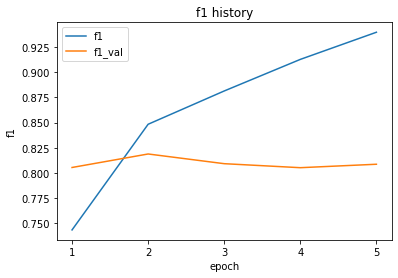

In [59]:
fig, ax = plt.subplots()
ax.set_title("f1 history")
ax.set_ylabel("f1")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['f1', 'f1_val']].plot(ax=ax)
plt.savefig("f1.png")